In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download data and preprocessing
# ==============================================================================
data = fetch_dataset(name='h2o', raw=True, verbose=False,
                     kwargs_read_csv={'header': 0, 'names': ['y', 'datetime']})

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

print(f"Length of time series: {len(data)}")
print(f"Frequency: {data.index.freqstr}")
data.head(3)

Length of time series: 204
Frequency: MS


,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


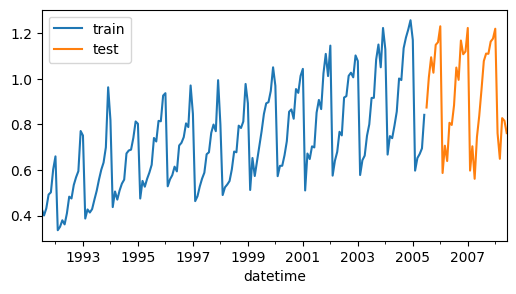

In [3]:
# Train-validation dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
data_train = data[:end_train].copy()
data_test = data[end_train:].copy()

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
ax.legend()
plt.show()

In [4]:
# Missing values
# ==============================================================================
print(
    f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')


# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

Number of rows with missing values: 0.0


True

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


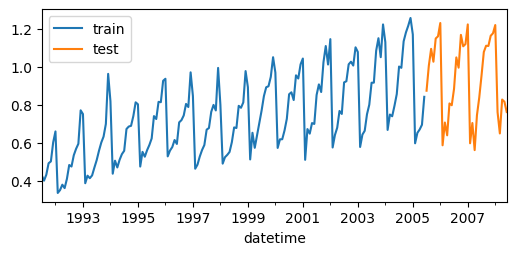

In [5]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

In [6]:
# Here we create our own lagged data and time gaps between the 
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
)

forecaster.fit(y=data_train['y'])

In [7]:
# Last window
# ==============================================================================
last_window = forecaster.last_window
last_window

datetime
2004-08-01    0.994864
2004-09-01    1.134432
2004-10-01    1.181011
2004-11-01    1.216037
2004-12-01    1.257238
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [8]:
# Dummy values to complete the last_window until the moment of prediction
# ==============================================================================
# These dummy values are never used by the model because they are always posterior to the
# smallest lag.
date_start_prediction = pd.to_datetime("2006-01-01")
# dummy_value = np.inf
dummy_value = np.random.rand()

last_window_extended = last_window.reindex(
    pd.date_range(start=last_window.index[0],
                  end=date_start_prediction, freq='MS'),
    fill_value=dummy_value
)

last_window_extended

2004-08-01    0.994864
2004-09-01    1.134432
2004-10-01    1.181011
2004-11-01    1.216037
2004-12-01    1.257238
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
2005-07-01    0.135772
2005-08-01    0.135772
2005-09-01    0.135772
2005-10-01    0.135772
2005-11-01    0.135772
2005-12-01    0.135772
2006-01-01    0.135772
Freq: MS, Name: y, dtype: float64

In [9]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=12, last_window=last_window_extended)
predictions.head(7)

2006-02-01    0.568134
2006-03-01    0.624020
2006-04-01    0.694049
2006-05-01    0.777620
2006-06-01    0.651535
2006-07-01    0.569053
2006-08-01    0.557568
Freq: MS, Name: pred, dtype: float64

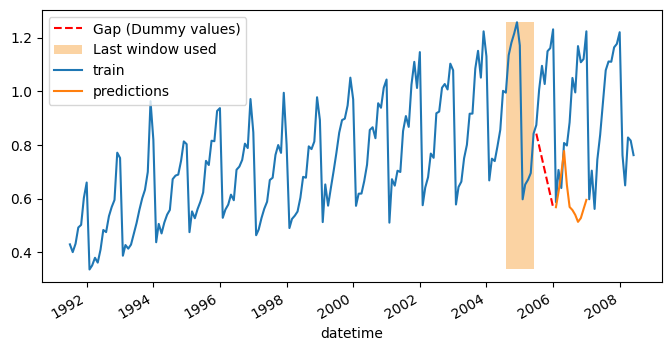

In [10]:
# Plot predictions
# ==============================================================================
last_window_used = (
    last_window_extended.index[0], last_window_extended.index[-8])
dummy_values = (last_window_extended.index[-7], last_window_extended.index[-1])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    [dummy_values[0], dummy_values[1]],
    [last_window.iloc[-1], predictions.iloc[0]],
    color='red',
    linestyle='--',
    label='Gap (Dummy values)'
)
ax.fill_between(last_window_used, data['y'].min(), data['y'].max(),
                facecolor='#f7931a', alpha=0.4, zorder=0, label='Last window used')
data['y'].plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()